# Analytics Vidhya - Game of Deep Learning | Computer Vision Hackathon

https://datahack.analyticsvidhya.com/contest/game-of-deep-learning/

Hackthon Timeframe: Friday May 24, 2019 - Sunday June 09, 2019

#### Problem Statement

Ship or vessel detection has a wide range of applications, in the areas of maritime safety,  fisheries management, marine pollution, defence and maritime security, protection from piracy, illegal migration, etc.

Keeping this in mind, a Governmental Maritime and Coastguard Agency is planning to deploy a computer vision based automated system to identify ship type only from the images taken by the survey boats. You have been hired as a consultant to build an efficient model for this project.

#### Dataset Description
There are 6252 images in train and 2680 images in test data. The categories of ships and their corresponding codes in the dataset are as follows -

There are 5 classes of ships to be detected which are as follows: <br>

1: Cargo <br>
2: Military <br>
3: Carrier <br>
4: Cruise <br>
5: Tankers

Variable	| Definition
--- | ---
image	| Name of the image in the dataset (ID column)
category |	Ship category code
<br>
#### Evaluation Metric
The Evaluation metric for this competition is weighted F1 Score.

#### Misc Rules
- Use of external dataset is not allowed, however, transfer learning can be used to build the solution

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import gc
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import adam
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

from numpy.random import seed
seed(2019)
from tensorflow import set_random_seed
set_random_seed(2019)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

# Basic EDA

In [2]:
# define the path for loading .jpg images
path = "../input/train/images"

train_files = pd.read_csv('../input/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('../input/test_ApKoW4T.csv')

In [3]:
train_files.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
test_files.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [5]:
# display missing categories in train
train_files[train_files.isnull().any(axis=1)]

,image,category


No missing values.

In [6]:
# dictionary ship encoding 
ship = {'Cargo': 1, 
        'Military': 2, 
        'Carrier': 3, 
        'Cruise': 4, 
        'Tankers': 5}

# reverse the ship type dictionary
ship = dict([[v,k] for k,v in ship.items()])

In [7]:
# Create test labels for interpretability
train_files['ship'] = train_files['category'].map(ship).astype('category')
labels = list(train_files['ship'].unique())

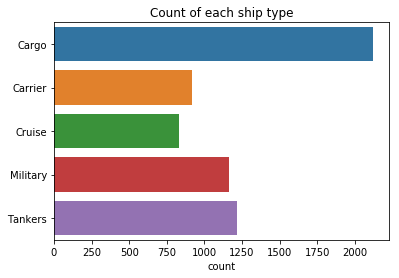

2293

In [8]:
# display count of ship types
plt.title('Count of each ship type')
sns.countplot(y=train_files['ship'].values)
plt.show()
gc.collect()

In [9]:
train_files['ship'].value_counts(normalize=False)

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: ship, dtype: int64

In [10]:
train_files['ship'].value_counts(normalize=True)

Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

Since there are class imbalances in training set, we will need to display a confusion matrix visualize to where the neural network classifier is having trouble. We will also stratify train_test_split in order to maintain the class distributions in both train and test.

# Encode Train Labels

In [11]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))

# Load Train/Test Files

In [12]:
# Since most pre-trained models have a specific input dimension,
# we will need to set the target_size to match the pre-trained model input shape.
# Increasing shape of the images requires more RAM.
def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [13]:
# Load Train and Test
X_train = load()
test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')
print(f'test shape: {test.shape}')

100%|██████████| 2680/2680 [00:04<00:00, 567.67it/s]


train dtype: float32
test dtype: float32
train shape: (6252, 224, 224, 3)
test shape: (2680, 224, 224, 3)


# View Some Train Images

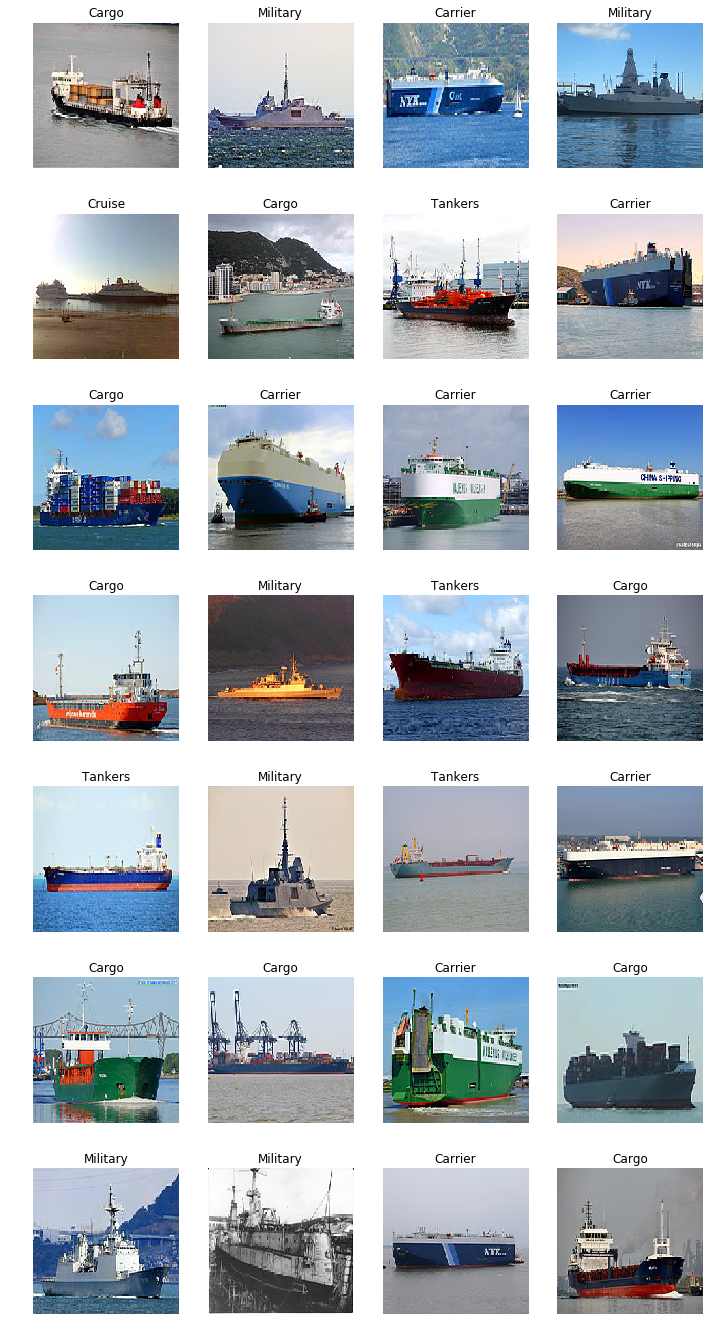

44777

In [14]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{train_files["ship"].values[i]}')
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
gc.collect()

# View Some Test Images

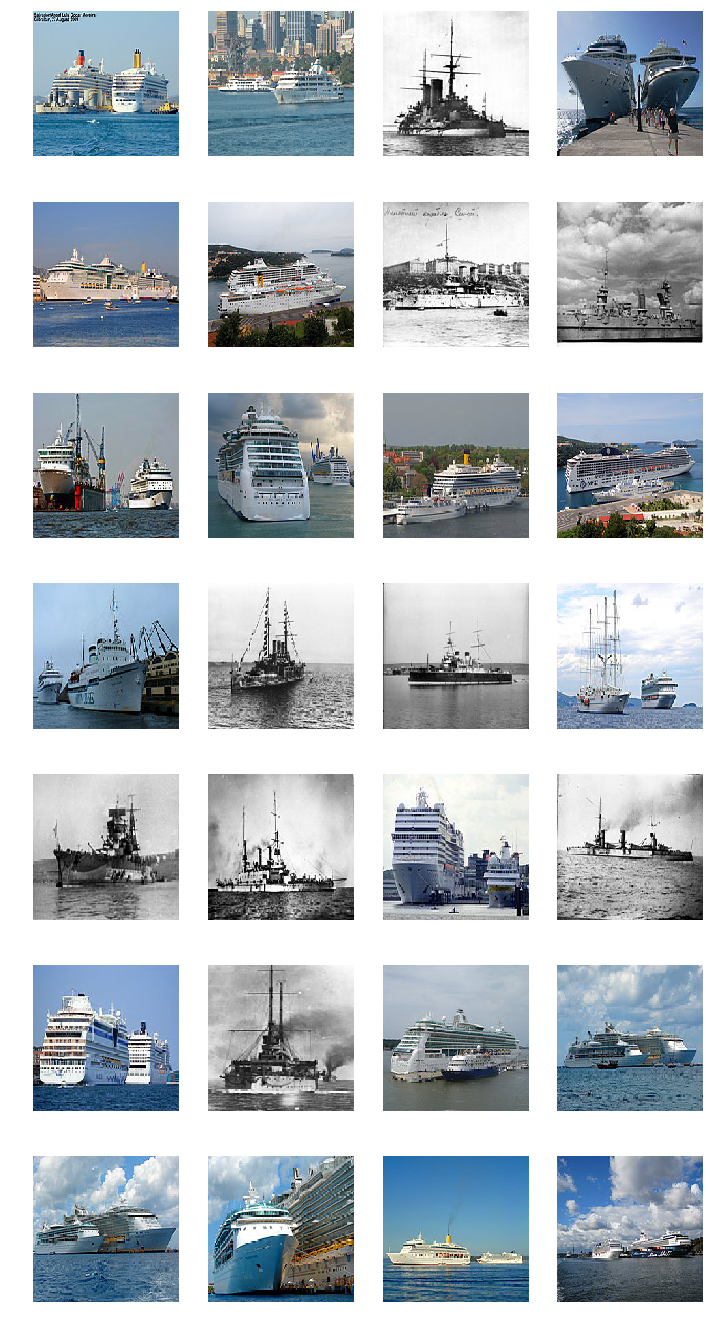

44726

In [15]:
# visualize the top 28 test images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.imshow(test[i])
    plt.axis('off')
plt.show()
del test # free up space for training
gc.collect()

There are black and white images mixed in with color images. Some images are old. Some images contain steam/smoke coming out of the smokestacks. Some images contain multiple ships. Some contain clouds and others contain various background scenery. Some contain a lengthwise display and others contain a display of the front of head of a ship. Some images are low contrast.

In order to address some of these concerns, such as grayscale, rotation, noise, etc. We will need to perform data augmentation to create a more robust training set for our Neural Network to learn from. This may help better generalize into testing dataset as well as help the network from overfitting to some extent.

Just looking at the top 28 ship images from train and test, it is not possible to tell how many edge cases there are, but on first glance, train and test appear to be fairly uniform. That is to say, validation scores should reflect test scores, unless you overfit the model.

# Custom Callbacks for F1 Score
We need to create a custom callbacks function that calculates f1 score after every epoch to gauge model performance.

In [16]:
class printf1(callbacks.Callback):
    def __init__(self, X_train, y_train):
        super(printf1, self).__init__()
        self.bestf1 = 0
        self.X_train = X_train
        self.y_train = y_train
        
    def on_epoch_end(self, epoch, logs={}):
        pred = np.argmax(self.model.predict(np.array(self.X_train)), axis=1)
        f1 = f1_score(np.argmax(self.y_train, axis=1), pred, average='weighted')
        print("Train F1 Score: {:.4f}".format(f1))
        pred = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        f1 = f1_score(np.argmax(self.validation_data[1], axis=1), pred, average='weighted')
        print("Valid F1 Score: {:.4f}".format(f1))
        return

In [17]:
# to plot training/validation history object
def plt_dynamic(x, vy, ty, ax, colors=['b'], title=''):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()
    plt.show()
    gc.collect()

In [18]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    gc.collect()

# Load Pre-trained network and weights (Xception)
Utilize Keras pre-trained model and weights for faster and more accurate image classification models. Weights were loaded from training on Imagenet dataset.

In [19]:
# make sure internet is enabled in the settings tab to the right
# do not include the last Fully Connected(FC) layer
from keras.applications.xception import Xception
model = Xception(include_top=False, input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 3s 0us/step


In [20]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

x = GlobalAveragePooling2D()(model.output)
#x = Dense(6, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# define new model
model = Model(model.inputs, output)
model.save('model.hdf5')
#model.summary()

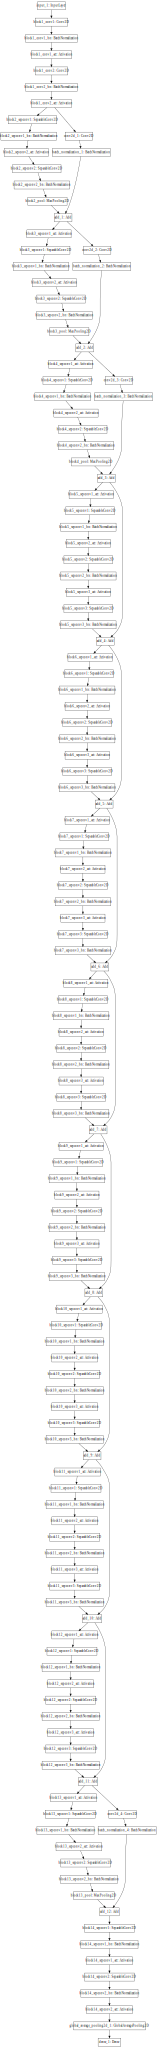

In [21]:
# visualize the Xception model architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Fine-tune Entire Pre-trained Xception Model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=2019,
                                                    test_size=0.2)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
gc.collect()

(5001, 224, 224, 3)
(1251, 224, 224, 3)
(5001, 5)
(1251, 5)


48967

Because no external data was allowed for this competition, it was crucial to modify (augment) the existing image dataset through the use of a data generator. Data augmentation may hurt or improve model performance so care must be taken at this step. Data augmentation needs to be considered case-by-case. So adding a vertical flip when none of the ships are flipped upside-down will likely decrease model generaliziblity to testing data.

Adaptive learning rates can help models converge to the optimal solution much better.

In [24]:
# use ImageDataGenerator to augment training data
from keras.preprocessing.image import ImageDataGenerator
batch_size = 8
epochs = 50

# make sure to keep learning rate low when fine-tuning
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=adam(lr=0.0001))

datagen = ImageDataGenerator(rotation_range=45, 
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             dtype='float32')

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train, y_train, 
                               batch_size=batch_size, 
                               seed=2019)

f1 = printf1(X_train, y_train)
cp = ModelCheckpoint('best.hdf5', monitor='val_loss', save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              validation_data=[X_test, y_test], 
                              callbacks=[cp,f1,annealer],
                              epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
626/625 [==============================] - 113s 181ms/step - loss: 0.7094 - acc: 0.7328 - val_loss: 0.3811 - val_acc: 0.8673
Train F1 Score: 0.8958
Valid F1 Score: 0.8604
Epoch 2/50
626/625 [==============================] - 103s 165ms/step - loss: 0.4452 - acc: 0.8371 - val_loss: 0.3679 - val_acc: 0.8753
Train F1 Score: 0.9256
Valid F1 Score: 0.8718
Epoch 3/50
626/625 [==============================] - 103s 165ms/step - loss: 0.3532 - acc: 0.8704 - val_loss: 0.2425 - val_acc: 0.9169
Train F1 Score: 0.9592
Valid F1 Score: 0.9170
Epoch 4/50
626/625 [==============================] - 104s 166ms/step - loss: 0.3104 - acc: 0.8836 - val_loss: 0.2679 - val_acc: 0.9097
Train F1 Score: 0.9495
Valid F1 Score: 0.9087
Epoch 5/50
626/625 [==============================] - 104s 166ms/step - loss: 0.2693 - acc: 0.9014 - val_loss: 0.2196 - val_acc: 0.9201
Train F1 Score: 0.9692
Valid F1 Score: 0.9204
Epoch 6/50
626/625 [======================

Best model weighted F1 Score: 0.9511
weighted F1 Score: 0.9528


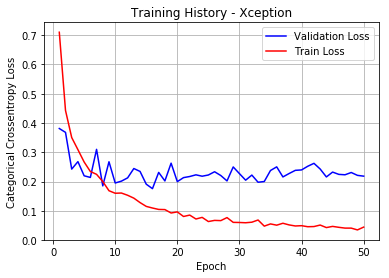

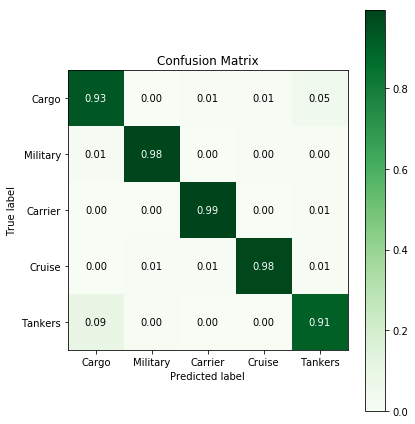

In [25]:
# printout competition metric - F1 score 
true = np.argmax(y_test, axis=1)
best = load_model('best.hdf5')
valid_pred_best = np.argmax(best.predict(X_test), axis=1)
best_f1_score = f1_score(true, valid_pred_best, average="weighted")
print(f'Best model weighted F1 Score: {best_f1_score:.4f}')

valid_pred = np.argmax(model.predict(X_test), axis=1)
f1_score = f1_score(true, valid_pred, average="weighted")
print(f'weighted F1 Score: {f1_score:.4f}')

# visualize training loss
fig, ax = plt.subplots(1,1)
vy = history.history['val_loss']
ty = history.history['loss']
ax.set_xlabel('Epoch')
x = list(range(1,epochs+1))
ax.set_ylabel('Categorical Crossentropy Loss')
plt_dynamic(x,vy,ty,ax, title='Training History - Xception')

#plot confusion matrix
plot_confusion_matrix(true, valid_pred, normalize=True, 
                      classes=labels, title='Confusion Matrix')

As you can see confusion matrix, the Neural Network is having a little trouble differentiating between _Cargos_ and _Tankers_. Xception is converging to minima quite nicely. There is over-fitting but not by much.

# Make Test Predictions

In [26]:
test = load('test')
sub = pd.read_csv('../input/sample_submission_ns2btKE.csv')

# use the better performing model
if best_f1_score >= f1_score:
    sub['category'] = np.argmax(best.predict(test), axis=1) + 1
else:
    sub['category'] = np.argmax(model.predict(test), axis=1) + 1 
sub.to_csv('submission.csv', index=False)
sub.head()

100%|██████████| 2680/2680 [00:04<00:00, 546.36it/s]


,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [27]:
sub['category'].map(ship).value_counts(normalize=True)

Cargo       0.338806
Tankers     0.191045
Military    0.188060
Carrier     0.148507
Cruise      0.133582
Name: category, dtype: float64

# End Notes
This concludes my solution to the Analytics Vidhya Computer Vision Hackathon. While this notebook is fairly basic, it gives a good template to work off and learn from, especially for beginners to image classification. There is certainly a lot more that can be added, such as balancing the classes through oversampling, data augmentation via external libraries/scripts and much more. With that being said, this notebook was able to achieve 95%+ in both public and private leaderboards. 5-fold CV certainly adds another percentage increase. Finally, due to memory constraints oversampling and 5-fold CV were not shown in this notebook.